<a href="https://colab.research.google.com/github/lizjwh/groupIAI_5take2/blob/main/5%20Completely%20New%20Model/Densenet_Model_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install libraries and download the dataset

In [1]:
!pip install torchvision
!pip install kaggle
!pip install tqdm
!pip install colorama
!pip install split-folders
!pip install tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 972.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 2.6 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
torch.manual_seed(0)
from torch import nn, optim, tensor
from torchvision import transforms, models ,datasets
from torch.utils.data import ConcatDataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import os
import splitfolders
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter

In [3]:
# Check whether we have a GPU.  Use it if we do.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
! export KAGGLE_USERNAME="emmet454" && export KAGGLE_KEY="ee00fbc0728a71f5c5f712029e3ef004" && kaggle datasets download --force --unzip emilyburt/intro-to-ai

100% 4.07G/4.08G [00:46<00:00, 70.4MB/s]
100% 4.08G/4.08G [00:46<00:00, 94.2MB/s]


#Split data into train, val and test

In [5]:
input_folder = 'Dataset/Full Mobility/Left hand'

#split with a ratio (train, val, test)
splitfolders.ratio(input_folder, output='Full Mobility/Left hand/',
                  seed=42, ratio=(.6, .2, .2),
                  group_prefix=None)

input_folder = 'Dataset/Full Mobility/Right hand'

#split with a ratio
splitfolders.ratio(input_folder, output='Full Mobility/Right hand/',
                  seed=42, ratio=(.6, .2, .2),
                  group_prefix=None)

input_folder = 'Dataset/Restricted mobility/Left hand'

#split with a ratio
splitfolders.ratio(input_folder, output='Restricted Mobility/Left hand/',
                  seed=42, ratio=(.6, .2, .2),
                  group_prefix=None)

input_folder = 'Dataset/Restricted mobility/Right hand'

#split with a ratio
splitfolders.ratio(input_folder, output='Restricted Mobility/Right hand/',
                  seed=42, ratio=(.6, .2, .2),
                  group_prefix=None)

Copying files: 492 files [00:07, 62.46 files/s]
Copying files: 502 files [00:04, 114.51 files/s]
Copying files: 484 files [00:06, 79.27 files/s]
Copying files: 495 files [00:08, 60.48 files/s]


In [6]:
def create_dataset(root_dir):
    """
    Creates an ImageFolder dataset from the specified root directory.
    """
    data_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.RandomRotation(30),
                                          transforms.RandomHorizontalFlip(p=0.3),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])
    dataset = datasets.ImageFolder(root_dir, transform=data_transforms)
    return dataset

def combine_datasets(root_folders):
    """
    Combines datasets from multiple root folders into one dataset.
    """
    datasets = [create_dataset(folder) for folder in root_folders]
    combined_dataset = ConcatDataset(datasets)

    # Extract class-to-index mappings from individual datasets and merge them
    class_to_idx = {}
    for dataset in datasets:
        class_to_idx.update(dataset.class_to_idx)

    return combined_dataset, class_to_idx


def main():
  #choose which folders to include in test here
    root_folders = ['/content/Restricted Mobility/Left hand/train',
                    '/content/Restricted Mobility/Right hand/train',
                    '/content/Full Mobility/Left hand/train',
                    '/content/Full Mobility/Right hand/train']

    combined_dataset, combined_dataset.class_to_idx = combine_datasets(root_folders)

    print(f"Class to index mapping: {combined_dataset.class_to_idx}")
    return combined_dataset

def main_val():
  #choose which folders to include in test here
    root_folders = ['/content/Restricted Mobility/Left hand/val',
                    '/content/Restricted Mobility/Right hand/val',
                    '/content/Full Mobility/Left hand/val',
                    '/content/Full Mobility/Right hand/val']

    combined_dataset, combined_dataset.class_to_idx = combine_datasets(root_folders)

    print(f"Class to index mapping: {combined_dataset.class_to_idx}")
    return combined_dataset

def main_test():
  #choose which folders to include in test here
    root_folders = ['/content/Restricted Mobility/Left hand/test',
                    '/content/Restricted Mobility/Right hand/test',
                    '/content/Full Mobility/Left hand/test',
                    '/content/Full Mobility/Right hand/test']

    combined_dataset, combined_dataset.class_to_idx = combine_datasets(root_folders)

    print(f"Class to index mapping: {combined_dataset.class_to_idx}")
    return combined_dataset

combined_train_dataset = main()
combined_val_dataset = main_val()
combined_test_dataset = main_test()

Class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'Space': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}
Class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'Space': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}
Class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'Space': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


#Create the densenet model

In [18]:
class SimplifiedModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimplifiedModel, self).__init__()

        # Load a pretrained DenseNet model
        densenet_model = models.densenet121(pretrained=True)

        # Use only the feature extractor part of DenseNet
        self.features = densenet_model.features

        # Modify the classifier part
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p=0.3), #next test for this
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Create an instance of the SimplifiedModel
model = SimplifiedModel(in_channels=3,num_classes=27).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

#Create the data loaders

In [8]:
#create loaders
train_loader = torch.utils.data.DataLoader(dataset=combined_train_dataset,
                                           batch_size=50,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=combined_val_dataset,
                                          batch_size=50,
                                          shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=combined_test_dataset,
                                          batch_size=32,
                                          shuffle=False)

# Train and test the model

In [16]:
from tqdm import tqdm
import math

# Set up a bunch of things
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()
steps=math.ceil(len(combined_train_dataset)/(train_loader.batch_size))

#Key constants
epochs = 5
print_every = 5

--------------------------------- START OF EPOCH [ 1 ] >>> LR =  0.001 ---------------------------------



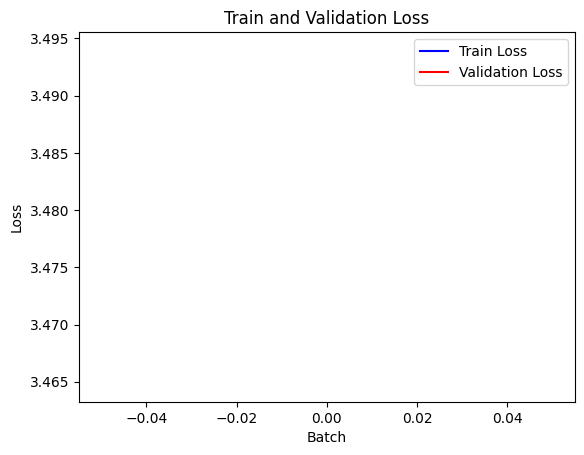

Epoch (1 of 5) ... Step  (  1 of 22) ... Train loss: 3.465 ... Test loss: 3.494


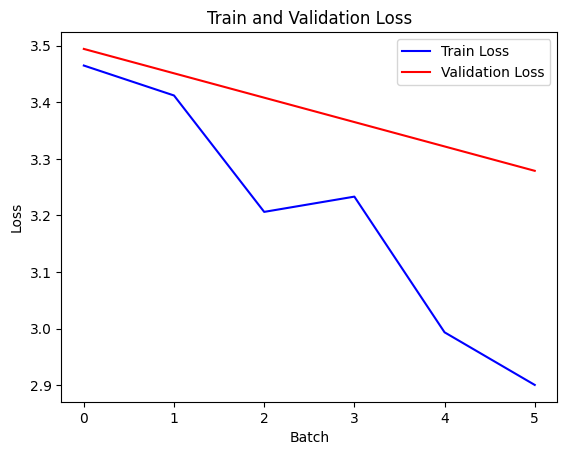

Epoch (1 of 5) ... Step  (  6 of 22) ... Train loss: 2.901 ... Test loss: 3.279


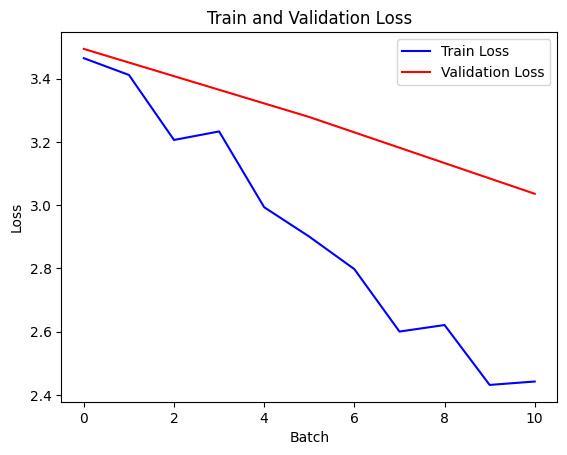

Epoch (1 of 5) ... Step  ( 11 of 22) ... Train loss: 2.442 ... Test loss: 3.036


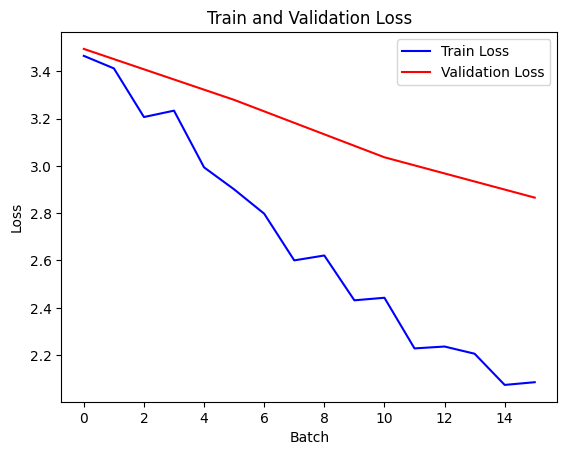

Epoch (1 of 5) ... Step  ( 16 of 22) ... Train loss: 2.086 ... Test loss: 2.866


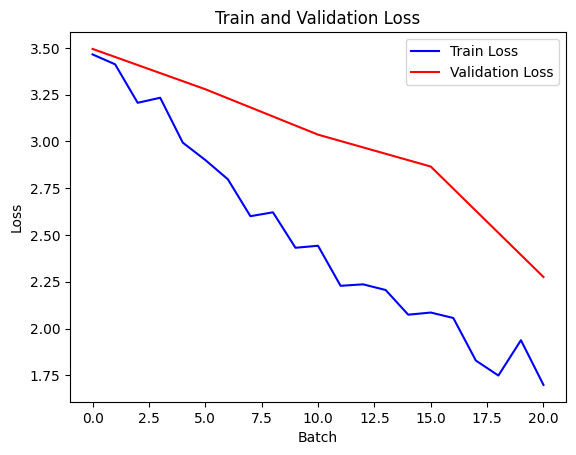

Epoch (1 of 5) ... Step  ( 21 of 22) ... Train loss: 1.699 ... Test loss: 2.275


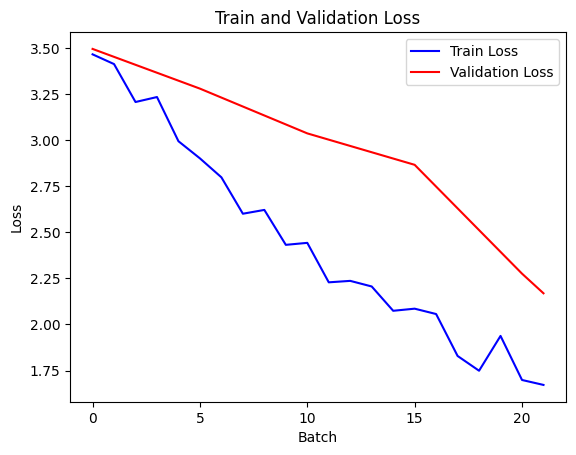

Epoch (1 of 5) ... Step  ( 22 of 22) ... Train loss: 1.672 ... Test loss: 2.169
--------------------------------- START OF EPOCH [ 2 ] >>> LR =  0.001 ---------------------------------



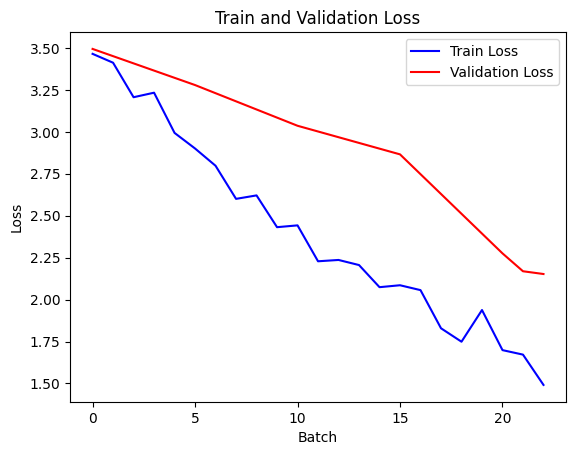

Epoch (2 of 5) ... Step  (  1 of 22) ... Train loss: 1.491 ... Test loss: 2.152


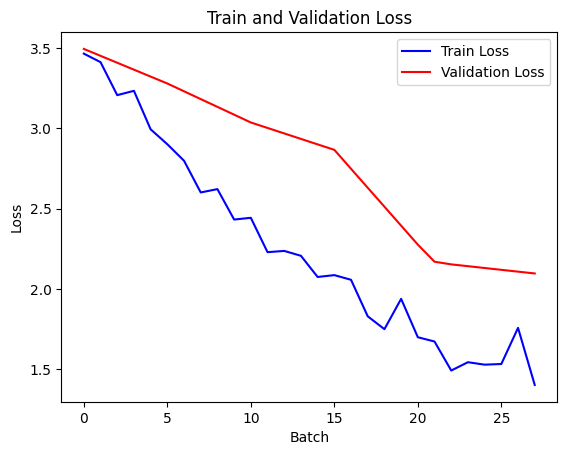

Epoch (2 of 5) ... Step  (  6 of 22) ... Train loss: 1.402 ... Test loss: 2.096


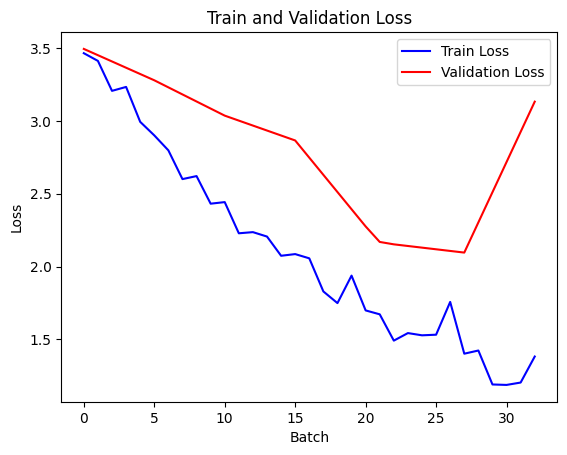

Epoch (2 of 5) ... Step  ( 11 of 22) ... Train loss: 1.382 ... Test loss: 3.132


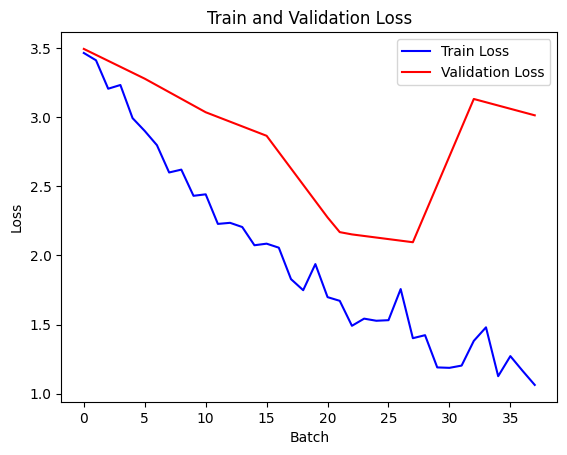

Epoch (2 of 5) ... Step  ( 16 of 22) ... Train loss: 1.064 ... Test loss: 3.014


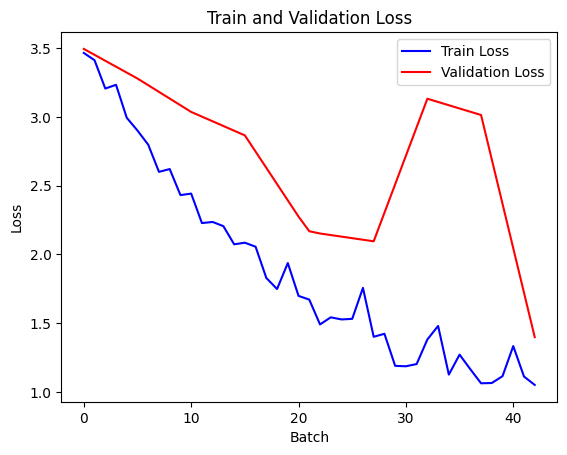

Epoch (2 of 5) ... Step  ( 21 of 22) ... Train loss: 1.052 ... Test loss: 1.399


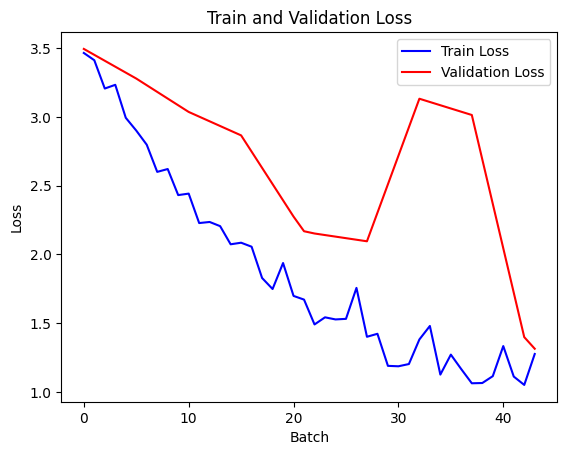

Epoch (2 of 5) ... Step  ( 22 of 22) ... Train loss: 1.277 ... Test loss: 1.315
--------------------------------- START OF EPOCH [ 3 ] >>> LR =  0.001 ---------------------------------



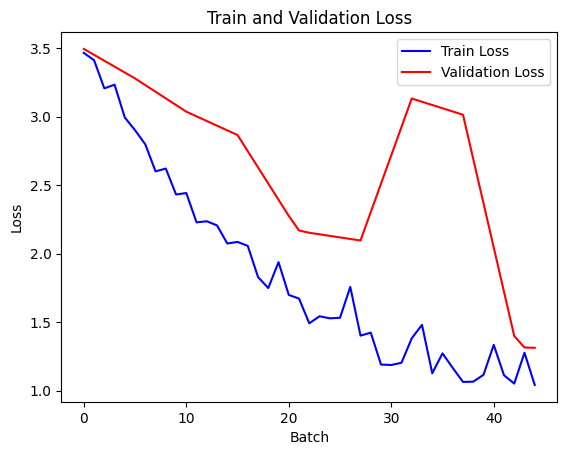

Epoch (3 of 5) ... Step  (  1 of 22) ... Train loss: 1.042 ... Test loss: 1.313


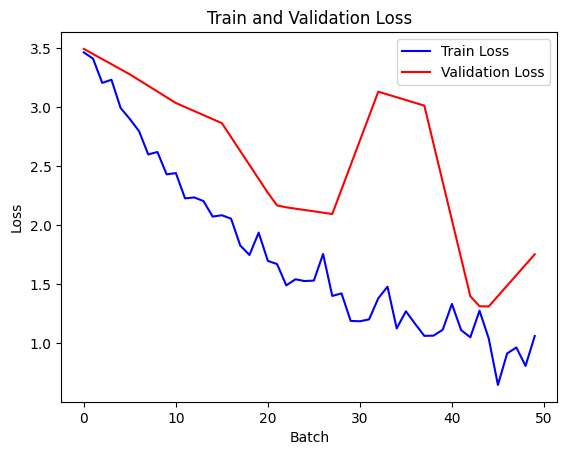

Epoch (3 of 5) ... Step  (  6 of 22) ... Train loss: 1.062 ... Test loss: 1.754


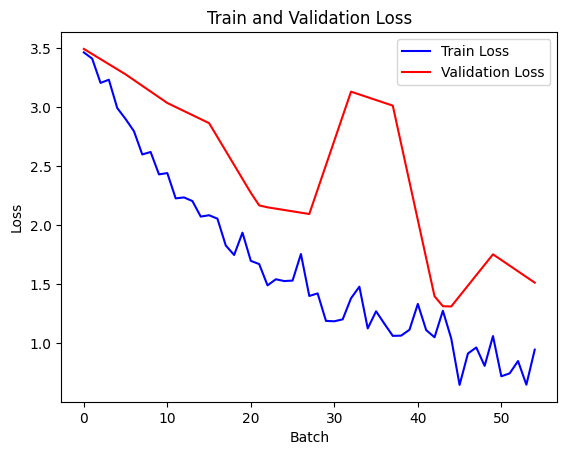

Epoch (3 of 5) ... Step  ( 11 of 22) ... Train loss: 0.947 ... Test loss: 1.515


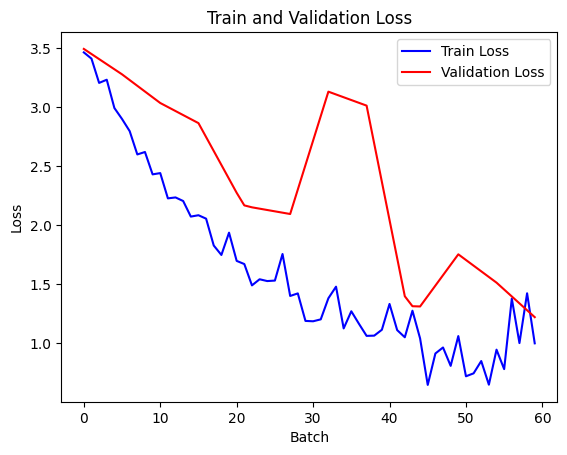

Epoch (3 of 5) ... Step  ( 16 of 22) ... Train loss: 1.001 ... Test loss: 1.222


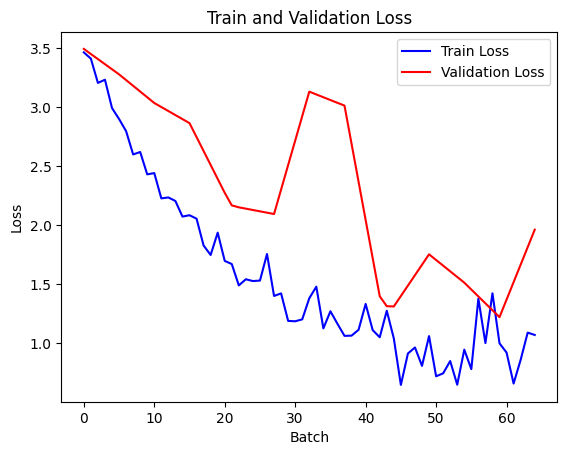

Epoch (3 of 5) ... Step  ( 21 of 22) ... Train loss: 1.072 ... Test loss: 1.963


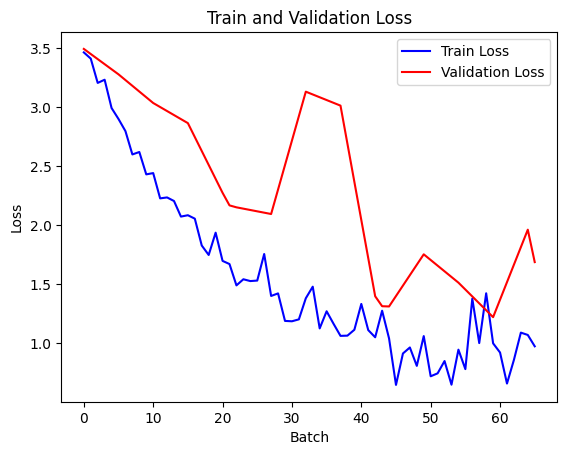

Epoch (3 of 5) ... Step  ( 22 of 22) ... Train loss: 0.975 ... Test loss: 1.688
--------------------------------- START OF EPOCH [ 4 ] >>> LR =  0.001 ---------------------------------



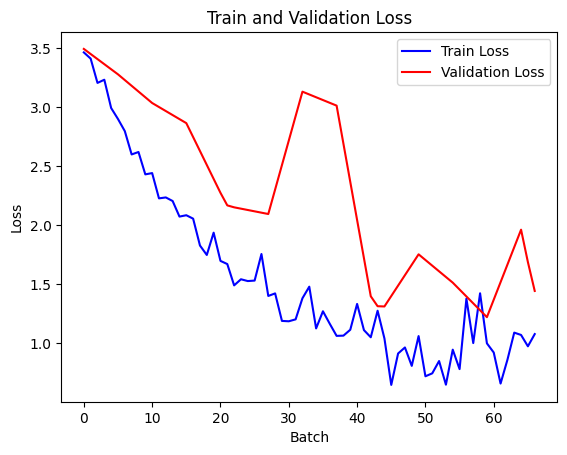

Epoch (4 of 5) ... Step  (  1 of 22) ... Train loss: 1.079 ... Test loss: 1.444


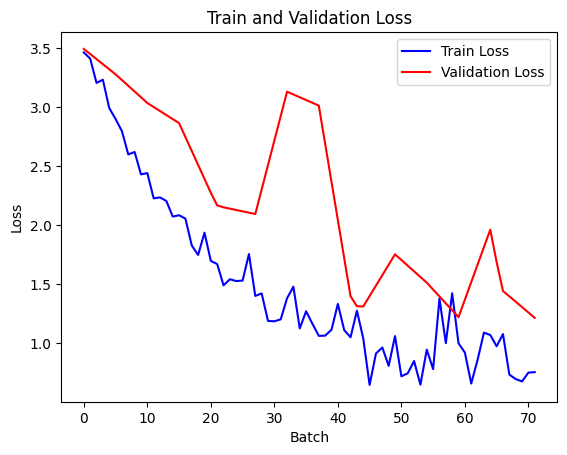

Epoch (4 of 5) ... Step  (  6 of 22) ... Train loss: 0.757 ... Test loss: 1.217


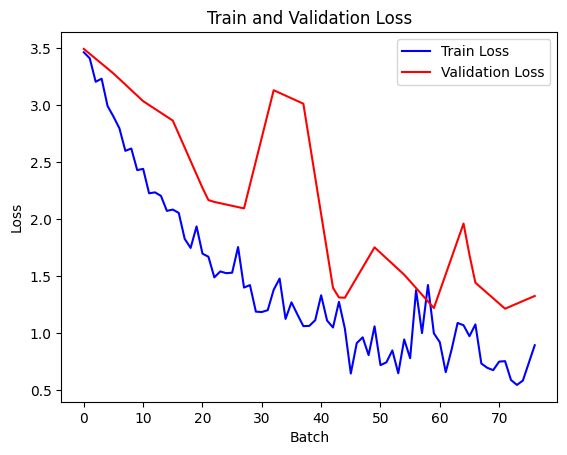

Epoch (4 of 5) ... Step  ( 11 of 22) ... Train loss: 0.896 ... Test loss: 1.328


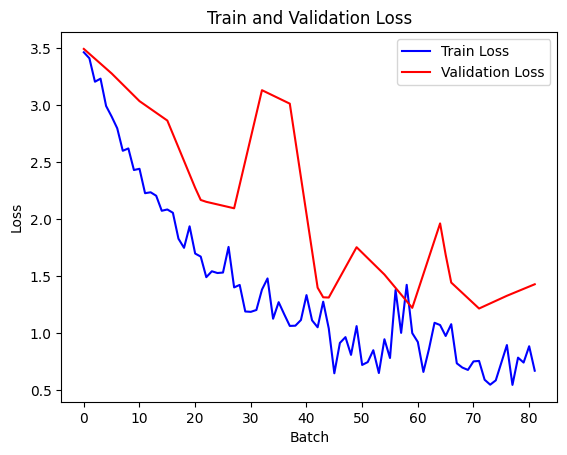

Epoch (4 of 5) ... Step  ( 16 of 22) ... Train loss: 0.671 ... Test loss: 1.429


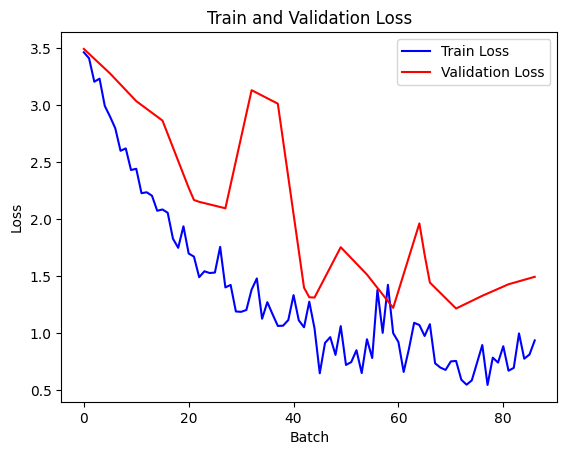

Epoch (4 of 5) ... Step  ( 21 of 22) ... Train loss: 0.937 ... Test loss: 1.495


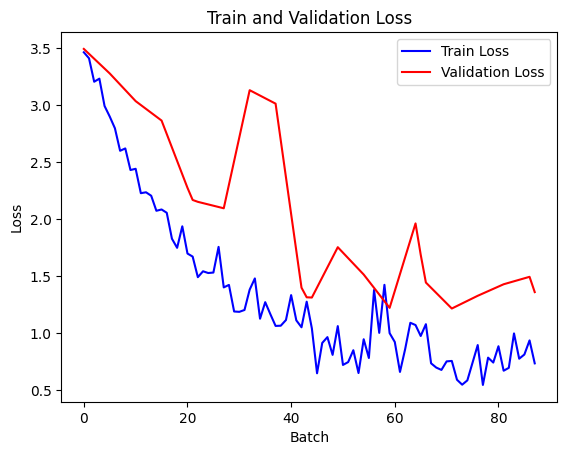

Epoch (4 of 5) ... Step  ( 22 of 22) ... Train loss: 0.735 ... Test loss: 1.360
--------------------------------- START OF EPOCH [ 5 ] >>> LR =  0.001 ---------------------------------



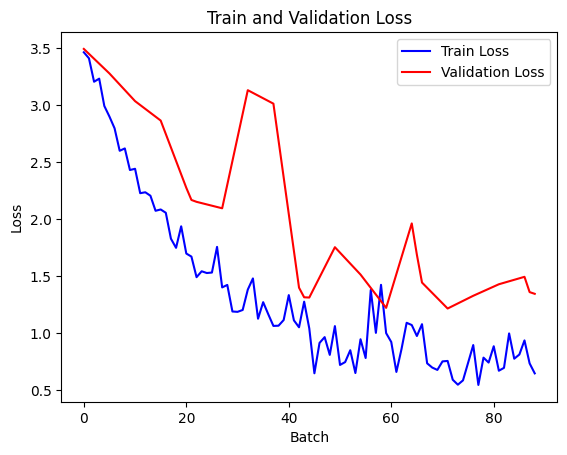

Epoch (5 of 5) ... Step  (  1 of 22) ... Train loss: 0.648 ... Test loss: 1.345


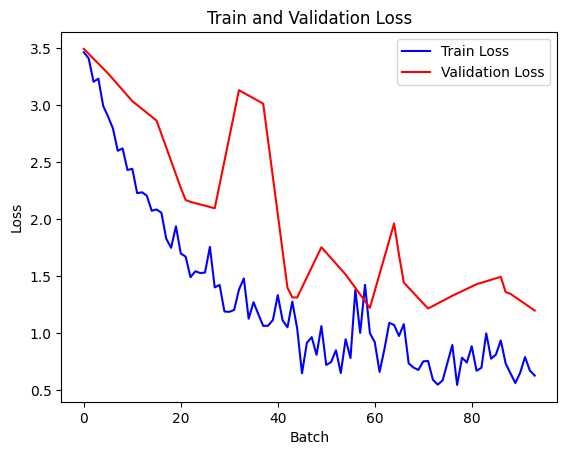

Epoch (5 of 5) ... Step  (  6 of 22) ... Train loss: 0.628 ... Test loss: 1.198


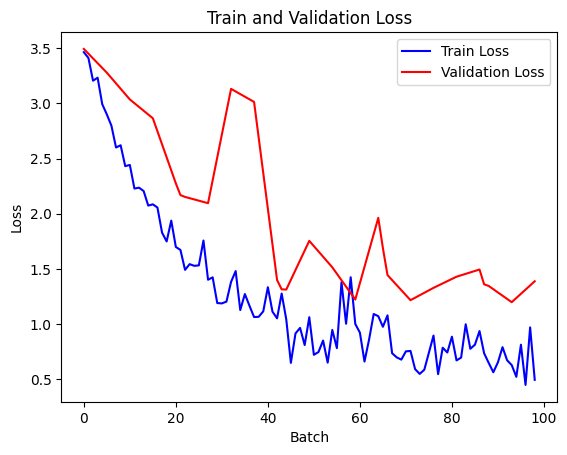

Epoch (5 of 5) ... Step  ( 11 of 22) ... Train loss: 0.495 ... Test loss: 1.388


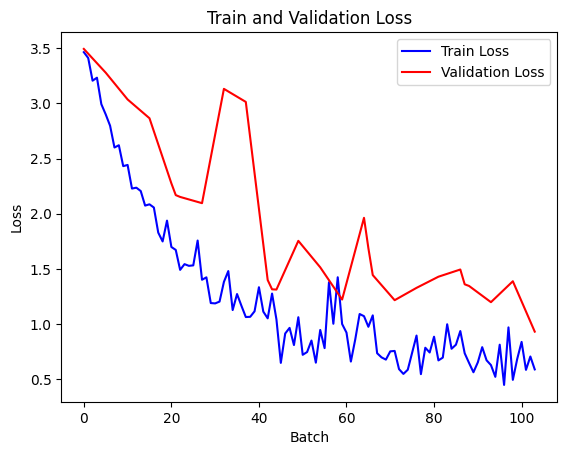

Epoch (5 of 5) ... Step  ( 16 of 22) ... Train loss: 0.589 ... Test loss: 0.932


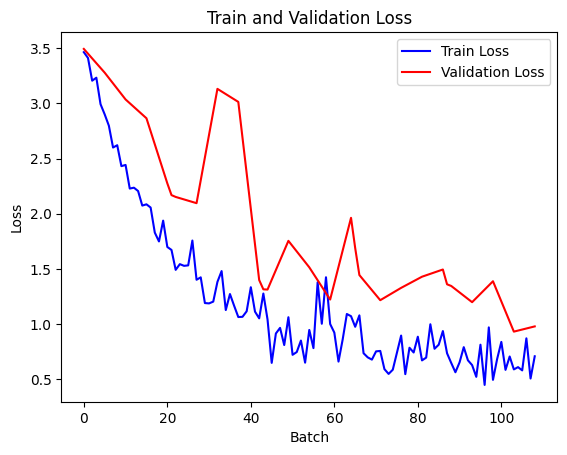

Epoch (5 of 5) ... Step  ( 21 of 22) ... Train loss: 0.708 ... Test loss: 0.979


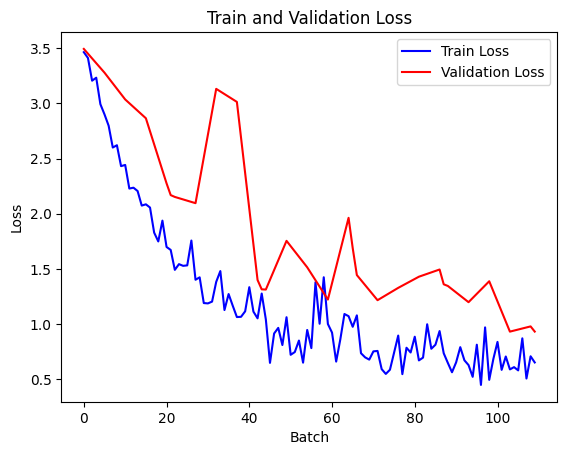

Epoch (5 of 5) ... Step  ( 22 of 22) ... Train loss: 0.652 ... Test loss: 0.932


In [19]:
train_loss_arr = []  # List to store training loss values
test_loss_arr = []   # List to store testing loss values
test_loss_step = []
step = 0  # Initialize step counter
count = 0

for epoch in range(epochs):
    print(f"--------------------------------- START OF EPOCH [ {epoch+1} ] >>> LR =  {optimizer.param_groups[-1]['lr']} ---------------------------------\n")

    for batch_idx, (images, labels) in enumerate(train_loader):
        model.train()
        step += 1
        count += 1
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = model(images)

        # Backpropagation and optimization
        loss = criterion(logits, labels)
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad()

        # Store training loss value
        train_loss_arr.append(loss.item())

        if (step % print_every == 1) or (step == steps):
            test_loss = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    props = model.forward(inputs)
                    batch_loss = criterion(props, labels)
                    test_loss += batch_loss.item()
            test_loss /= len(test_loader)  # Divide by total batches to get average test loss
            test_loss_arr.append(test_loss)  # Store testing loss value
            test_loss_step.append(count - 1)  # Storing batch number for test loss

            # Plotting the losses
            plt.plot(train_loss_arr, label='Train Loss', color='blue')
            plt.plot(test_loss_step, test_loss_arr, label='Validation Loss', color='red')
            plt.xlabel('Batch')
            plt.ylabel('Loss')
            plt.title('Train and Validation Loss')
            plt.legend()
            plt.show()

            tqdm.write(f"Epoch ({epoch+1} of {epochs}) ... "
                       f"Step  ({step:3d} of {steps}) ... "
                       f"Train loss: {train_loss_arr[-1]:.3f} ... "
                       f"Test loss: {test_loss_arr[-1]:.3f}")
    scheduler.step()
    step = 0

#Save the model

In [20]:
torch.save(model.state_dict(), 'Pretrained Densenet - v2.pth')

#Test the model on the combined_train_dataset after training

Test accuracy : 66.34980988593156 %


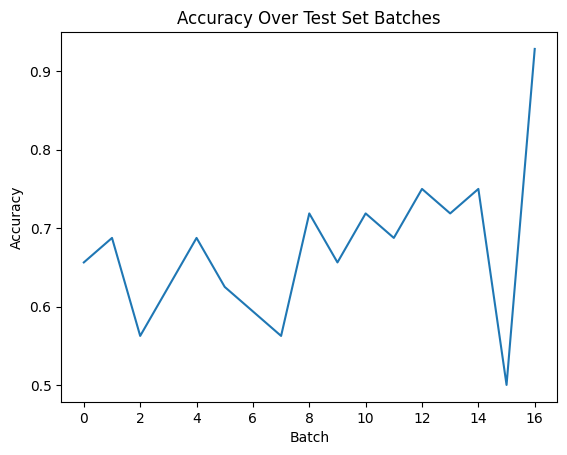

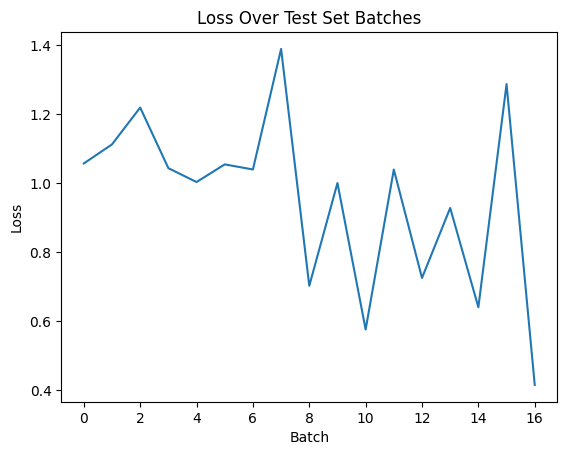

526 ['E', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'Space', 'C', 'C', 'C', 'F', 'Z', 'D', 'F', 'D', 'I', 'A', 'A', 'E', 'E', 'E', 'B', 'B', 'F', 'F', 'F', 'F', 'G', 'G', 'G', 'G', 'U', 'H', 'H', 'H', 'H', 'Z', 'I', 'Y', 'I', 'D', 'Z', 'J', 'J', 'J', 'J', 'B', 'V', 'K', 'V', 'K', 'L', 'L', 'T', 'L', 'T', 'M', 'M', 'M', 'M', 'M', 'N', 'M', 'N', 'N', 'M', 'O', 'F', 'O', 'O', 'H', 'Z', 'P', 'P', 'G', 'G', 'Q', 'Q', 'Q', 'Q', 'Q', 'Z', 'R', 'R', 'R', 'F', 'E', 'E', 'E', 'E', 'O', 'Space', 'Space', 'Space', 'Y', 'T', 'T', 'T', 'T', 'B', 'F', 'F', 'U', 'F', 'V', 'V', 'V', 'V', 'W', 'W', 'B', 'B', 'W', 'F', 'X', 'X', 'G', 'X', 'X', 'Y', 'D', 'Y', 'Y', 'X', 'V', 'D', 'Z', 'Z', 'E', 'A', 'E', 'S', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'C', 'Space', 'C', 'C', 'C', 'Z', 'D', 'D', 'F', 'I', 'A', 'E', 'E', 'E', 'E', 'F', 'F', 'F', 'F', 'F', 'G', 'G', 'X', 'G', 'G', 'H', 'H', 'H', 'H', 'H', 'J', 'I', 'I', 'D', 'J', 'Z', 'J', 'K', 'J', 'J', 'K', 'V', 'K', 'K', 'W', 'T', 'T', 'T', 'T', 'T', 'M', 'M', 

In [23]:
def test(epoch):
    # Do one pass over the test data.
    # In the test phase, don't need to compute gradients (for memory efficiency)
    pred = []
    true = []

    with torch.no_grad():
        correct = 0
        total = 0
        accuracies = []
        losses = []
        for images, labels in test_loader:
            #Convert image pixels to vector
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(images).squeeze((-1, -2))

            # Calculate loss
            loss = criterion(logits, labels)
            losses.append(loss.item())  # Append the loss to the list

            # Compute total correct so far
            predicted = torch.argmax(logits, -1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Calculate accuracy for the current batch
            batch_accuracy = (predicted == labels).sum().item() / labels.size(0)
            accuracies.append(batch_accuracy)

            # Convert predicted and true labels to class names
            try:
                pred.extend([classes[label.item()] for label in predicted])
                true.extend([classes[label.item()] for label in labels])
                #print(pred, true)
            except KeyError as e:
                print(f"Error: {e} not found in classes dictionary.")
                print(f"Problematic labels: {predicted}, {labels}")

        print(f'Test accuracy : {100 * correct / total} %')

        # Plot accuracy graph
        plt.plot(accuracies)
        plt.title('Accuracy Over Test Set Batches')
        plt.xlabel('Batch')
        plt.ylabel('Accuracy')
        plt.show()

        # Plot loss graph
        plt.plot(losses)
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title('Loss Over Test Set Batches')
        plt.show()

    return total, pred, true

# Run training
model.eval()
classes = combined_test_dataset.class_to_idx
classes = {value: key for key, value in classes.items()}

total, pred, true = test(1)
print(total, pred, true)

#Confusion Matrix

In [ ]:
def test(classes, test_loader):
    pred = []
    true = []

    with torch.no_grad():
        # Iterate through all batches in the test_loader
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass through the model
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Convert predicted and true labels to class names
            try:
                pred.extend([classes[label.item()] for label in predicted])
                true.extend([classes[label.item()] for label in labels])
                #print(pred, true)
            except KeyError as e:
                print(f"Error: {e} not found in classes dictionary.")
                print(f"Problematic labels: {predicted}, {labels}")

    return pred, true

#invert class_to_idx keys to values and vice versa.
classes = combined_test_dataset.class_to_idx
classes = {value: key for key, value in classes.items()}

pred, true = test(classes, test_loader)
print(pred, true)

Number of images predicted: 526
{'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D', 'E': 'E', 'F': 'F', 'G': 'G', 'H': 'H', 'I': 'I', 'J': 'J', 'K': 'K', 'L': 'L', 'M': 'M', 'N': 'N', 'O': 'O', 'P': 'P', 'Q': 'Q', 'R': 'R', 'S': 'S', 'Space': 'Space', 'T': 'T', 'U': 'U', 'V': 'V', 'W': 'W', 'X': 'X', 'Y': 'Y', 'Z': 'Z'}


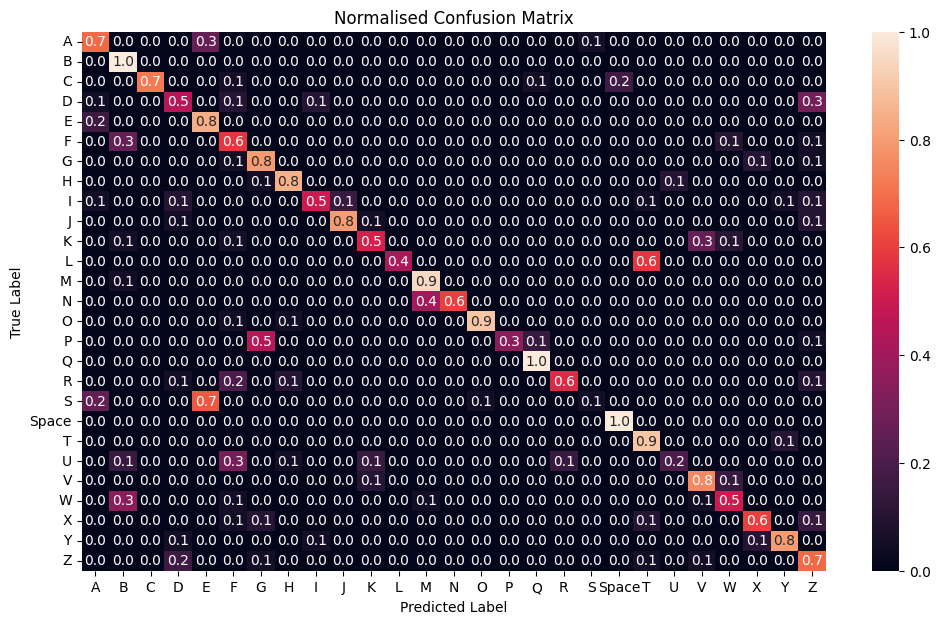

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def plotConfusionMatrix(pred, true, classes):
    # Change classes dictionary to this format {'A': 'A', 'B': 'B', 'C': 'C'...} for labelling the axis later
    classes = {value: value for key, value in classes.items()}

    # Convert class_to_idx dictionary to list of class names
    unique_classes = sorted(set(true + pred))

    # Ensure that all classes are included, even if they are not present in the batch of data
    all_classes = sorted(set(classes.values()))

    # Create confusion matrix
    cf_matrix = confusion_matrix(
        [classes[label] for label in true],
        [classes[label] for label in pred],
        labels=all_classes
    )

    # Create DataFrame using class names for index and columns
    df_cm = pd.DataFrame(cf_matrix, index=all_classes, columns=all_classes)

    # Normalize the confusion matrix by row (i.e., by the number of true instances for each class)
    df_cm = df_cm.div(df_cm.sum(axis=1), axis=0)

    # Add 0s to empty cells
    df_cm = df_cm.fillna(0)
    #print(df_cm)

    plt.figure(figsize=(12, 7))
    print(classes)
    sn.heatmap(df_cm, annot=True, fmt=".1f")  # Adjust fmt as needed for displaying float values
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalised Confusion Matrix')
    plt.show()


# # #To run this cell independently you need these lines and some sample predictions
# classes = combined_dataset.class_to_idx
# classes = {value: key for key, value in classes.items()}
# pred = ['A', 'M', 'K', 'I', 'Space', 'M', 'K', 'L', 'O', 'M', 'A', 'S', 'P', 'D', 'D', 'O', 'Space', 'A', 'B', 'V', 'Space', 'N', 'B', 'E', 'A', 'S', 'C', 'U', 'K', 'Z', 'X', 'Z', 'G', 'Z', 'J', 'A', 'X', 'G', 'A', 'Q', 'C', 'D', 'M', 'A', 'R', 'A', 'I', 'W', 'E', 'I', 'A', 'M', 'A', 'T', 'K', 'E', 'O', 'O', 'E', 'I', 'K', 'F', 'C', 'F', 'Z', 'E', 'E', 'S', 'J', 'Q', 'I', 'U', 'X', 'H', 'R', 'H', 'C', 'T', 'R', 'P', 'Space', 'I', 'J', 'B', 'N', 'H', 'M', 'Y', 'Y', 'E', 'G', 'O', 'Space', 'Space', 'C', 'G', 'T', 'V', 'M', 'J', 'A', 'W', 'G', 'P', 'H', 'Space', 'L', 'B', 'G', 'Y', 'Space', 'O', 'D', 'P', 'J', 'K', 'T', 'J', 'U', 'D', 'A', 'M', 'V', 'T', 'L', 'Q', 'L', 'C', 'E', 'T', 'H', 'R', 'I', 'R', 'R', 'N', 'C', 'Y', 'X', 'U', 'H', 'B', 'O', 'W', 'H', 'W', 'R', 'I', 'U', 'U', 'T', 'U', 'Q', 'J', 'M', 'F', 'X', 'R', 'Z', 'T', 'Q', 'R', 'Q', 'N', 'B', 'P', 'A', 'V', 'B', 'X', 'U', 'J', 'J', 'T', 'L', 'E', 'Space', 'C', 'E', 'D', 'T', 'E', 'U', 'N', 'O', 'T', 'R', 'E', 'G', 'J', 'Q', 'F', 'D', 'I', 'O', 'A', 'V', 'U', 'J', 'H', 'S', 'C', 'N', 'F', 'U', 'K', 'N', 'Space', 'H', 'E', 'W', 'L', 'F', 'Q', 'P', 'O', 'B', 'J', 'R', 'X', 'A', 'N', 'W', 'B', 'C', 'D', 'U', 'T', 'W', 'H', 'N', 'U', 'R', 'G', 'A', 'L', 'H', 'B', 'M', 'J', 'G', 'T', 'F', 'M', 'S', 'S', 'L', 'X', 'P', 'G', 'I', 'Q', 'R', 'J', 'P', 'Q', 'F', 'K', 'R', 'G', 'N', 'A', 'L', 'B', 'J', 'G', 'W', 'L', 'V', 'M', 'X', 'Y', 'J', 'P', 'L', 'A', 'F', 'V', 'S', 'Y', 'Z', 'R', 'Z', 'A', 'G', 'U', 'O', 'K', 'P', 'C', 'I', 'R', 'Y', 'C', 'B', 'W', 'J', 'I', 'R', 'B', 'P', 'Z', 'H', 'V', 'J', 'R', 'K', 'H', 'L', 'F', 'C', 'Q', 'G', 'V', 'Q', 'V', 'I', 'Q', 'F', 'N', 'Space', 'H', 'J', 'C', 'K', 'M', 'M', 'K', 'P', 'X', 'P', 'B', 'O', 'I', 'G', 'W', 'W', 'B', 'G', 'G', 'U', 'Space', 'M', 'I', 'I', 'O', 'P', 'D', 'C', 'A', 'E', 'R', 'Y', 'Space', 'I', 'M', 'V', 'R', 'Y', 'W', 'F', 'N', 'Y', 'I', 'T', 'F', 'E', 'X', 'N', 'R', 'S', 'Y', 'Z', 'R', 'X', 'T', 'P', 'B', 'E', 'K', 'K', 'M', 'S', 'F', 'H', 'Z', 'W', 'M', 'N', 'H', 'A', 'E', 'P', 'J', 'Z', 'Space', 'W', 'B', 'Y', 'C', 'T', 'Z', 'A', 'X', 'S', 'M', 'E', 'Z', 'T', 'P', 'Space', 'Z', 'H', 'V', 'Z', 'L', 'Y', 'E', 'C', 'E', 'Z', 'X', 'E', 'O', 'R', 'N', 'R', 'A', 'F', 'Y', 'Y', 'A', 'E', 'W', 'S', 'B', 'S', 'X', 'F', 'Y', 'Z', 'T', 'C', 'U', 'R', 'K', 'T', 'E', 'H', 'O', 'U', 'V', 'O', 'Z', 'D', 'M', 'Q', 'W', 'G', 'Z', 'W', 'H', 'V', 'N', 'T', 'N', 'Z', 'B', 'S', 'Space', 'Y', 'N', 'J', 'Space', 'G', 'E', 'O', 'K', 'A', 'I', 'R', 'E', 'H', 'S', 'Y', 'N', 'W', 'T', 'I', 'E', 'W', 'U', 'V', 'T', 'Q', 'V', 'P', 'P', 'A', 'H', 'S', 'W', 'U', 'S', 'T', 'O', 'O', 'B', 'F', 'T', 'V', 'J', 'Y', 'X', 'J', 'P', 'L', 'O', 'Q', 'F', 'P', 'U', 'G', 'X', 'Q', 'Y', 'Space', 'D', 'R', 'A', 'J', 'T', 'Z', 'Space', 'S', 'P', 'I', 'R', 'G', 'T', 'I', 'Q', 'Space', 'X', 'V', 'R', 'P', 'H', 'M', 'F', 'B', 'G', 'C', 'Q', 'P', 'Z', 'P', 'E', 'O', 'Z', 'P', 'Space', 'U', 'H', 'Y', 'Y', 'E', 'X', 'G', 'I', 'Z', 'U', 'M', 'Q', 'X', 'O', 'J', 'C', 'P', 'Y', 'O', 'G', 'Z', 'J', 'N', 'K', 'I', 'Y', 'I', 'C', 'K', 'Q', 'J', 'D', 'W', 'X', 'Y', 'F', 'U', 'S', 'U', 'F', 'K', 'Z', 'H', 'L', 'A', 'L', 'F', 'A', 'I', 'A', 'Z', 'L', 'B', 'L', 'F', 'R', 'A', 'B', 'Q', 'S', 'Space', 'W', 'P', 'D', 'G', 'R', 'U', 'L', 'I', 'E', 'N', 'S', 'A', 'D', 'H', 'X', 'A', 'W', 'Q', 'K', 'E', 'J', 'M', 'M', 'K', 'D', 'Space', 'Space', 'H', 'Y', 'C', 'E', 'D', 'B', 'S', 'J', 'T', 'U', 'T', 'W', 'A', 'H', 'T', 'J', 'J', 'D', 'N', 'M', 'A', 'O', 'D', 'V', 'Space', 'J', 'M', 'D', 'J', 'P', 'H', 'T', 'U', 'X', 'Z', 'Z', 'Space', 'B', 'H', 'L', 'D', 'N', 'C', 'P', 'D', 'Q', 'Space', 'C', 'V', 'F', 'U', 'I', 'T', 'X', 'D', 'A', 'K', 'O', 'S', 'N', 'I', 'Space', 'U', 'Q', 'Y', 'C', 'S', 'G', 'E', 'L', 'K', 'Y', 'S', 'G', 'A', 'N', 'S', 'Y', 'K', 'S', 'K', 'V', 'V', 'Y', 'H', 'I', 'K', 'M', 'C', 'T', 'C', 'B', 'X', 'L', 'K', 'H', 'U', 'W', 'D', 'T', 'W', 'E', 'W', 'H', 'J', 'E', 'K', 'X', 'V', 'U', 'C', 'T', 'S', 'N', 'Space', 'K', 'C', 'Space', 'A', 'E', 'B', 'D', 'Q', 'Z', 'X', 'C', 'F', 'Space', 'O', 'N', 'A', 'I', 'D', 'K', 'K', 'V', 'Z', 'M', 'Space', 'P', 'P', 'J', 'L', 'J', 'X', 'Z', 'M', 'G', 'L', 'M', 'O', 'D', 'Space', 'S', 'R', 'T', 'Space', 'X', 'R', 'N', 'X', 'F', 'B', 'I', 'I', 'L', 'X', 'X', 'D', 'H', 'A', 'D', 'C', 'H', 'U', 'E', 'V', 'L', 'U', 'V', 'R', 'F', 'H', 'A', 'K', 'F', 'E', 'Space', 'V', 'Q', 'O', 'S', 'O', 'X', 'K', 'Q', 'P', 'F', 'A', 'N', 'I', 'I', 'U', 'G', 'C', 'P', 'C', 'W', 'A', 'M', 'W', 'W', 'F', 'A', 'X', 'J', 'R', 'H', 'S', 'T', 'P', 'L', 'U', 'Y', 'W', 'K', 'W', 'B', 'C', 'F', 'B', 'Space', 'D', 'B', 'Space', 'J', 'X', 'T', 'N', 'Space', 'M', 'F', 'L', 'C', 'X', 'D', 'E', 'M', 'J', 'S', 'W', 'I', 'X', 'E', 'W', 'G', 'B', 'M', 'C', 'E', 'I', 'R', 'J', 'Q', 'I', 'B', 'N', 'E', 'F', 'T', 'R', 'J', 'B', 'C', 'E', 'O', 'H', 'A', 'V', 'Z', 'O', 'N', 'X', 'G', 'A', 'N', 'W', 'Y', 'P', 'I', 'B', 'O', 'B', 'H', 'P', 'L', 'T', 'Q', 'E', 'V', 'M', 'I', 'N', 'Q', 'I', 'H', 'N', 'E', 'U', 'T', 'P', 'G', 'Space', 'J', 'H', 'S', 'Y', 'V', 'P', 'A', 'C', 'G', 'C', 'O', 'V', 'N', 'O', 'U', 'U', 'A', 'Z', 'Y', 'D', 'R', 'W', 'F', 'Y', 'Q', 'I', 'F', 'T', 'E', 'Y', 'G', 'A', 'F', 'L', 'O', 'Z', 'J', 'V', 'W', 'S', 'P', 'R', 'W', 'B', 'Space', 'N', 'N', 'X', 'F', 'Z', 'Space', 'O', 'K', 'K', 'G', 'B', 'Y', 'M', 'X', 'R', 'V', 'Y', 'E', 'Z', 'N', 'A', 'X', 'M', 'Q', 'V', 'I', 'T', 'E', 'A', 'Q', 'O', 'E', 'U', 'F', 'J', 'V', 'S', 'S', 'J', 'O', 'P', 'K', 'A', 'X', 'G', 'P', 'N', 'M', 'Z', 'T', 'T', 'H', 'D', 'O', 'V', 'X', 'T', 'Q', 'D', 'S', 'Q', 'M', 'D', 'R', 'G', 'W', 'W', 'F', 'R', 'K', 'Space', 'L', 'P', 'L', 'V', 'J', 'N', 'G', 'B', 'U', 'Space', 'P', 'M', 'T', 'A', 'R', 'Y', 'B', 'A', 'Q', 'S', 'D', 'A', 'J', 'U', 'B', 'G', 'B', 'H', 'V', 'N', 'H', 'S', 'G', 'K', 'Space', 'R', 'M', 'K', 'Space', 'J', 'S', 'O', 'W', 'Q', 'Q', 'L', 'C', 'G', 'G', 'N', 'M', 'F', 'E', 'Q', 'R', 'G', 'P', 'F', 'V', 'E', 'B', 'D', 'A', 'E', 'Y', 'F', 'A', 'L', 'E', 'C', 'Z', 'I', 'P', 'F', 'G', 'C', 'R', 'Q', 'A', 'W', 'D', 'G', 'T', 'D', 'F', 'G', 'M', 'I', 'G', 'B', 'L', 'H', 'M', 'V', 'Space', 'B', 'V', 'I', 'C', 'Q', 'W', 'F', 'D', 'Z', 'R', 'E', 'X', 'O', 'F', 'U', 'T', 'D', 'J', 'P', 'I', 'R', 'J', 'D', 'G', 'L', 'Y', 'A', 'L', 'O', 'Z', 'A', 'B', 'Y', 'N', 'A', 'Space', 'C', 'E', 'C', 'C', 'A', 'X', 'E', 'K', 'D', 'X', 'P', 'K', 'B', 'F', 'N', 'K', 'X', 'N', 'U', 'U', 'D', 'A', 'R', 'J', 'V', 'X', 'Z', 'K', 'Z', 'L', 'C', 'X', 'C', 'G', 'R', 'A', 'H', 'I', 'B', 'G', 'C', 'S', 'D', 'J', 'K', 'J', 'W', 'U', 'V', 'T', 'P', 'C', 'C', 'I', 'C', 'N', 'B', 'W', 'Z', 'S', 'B', 'V', 'R', 'R', 'E', 'M', 'W', 'K', 'L', 'G', 'F', 'X', 'L', 'E', 'P', 'Y', 'Z', 'P', 'Y', 'C', 'I', 'G', 'G', 'L', 'Y', 'Z', 'B', 'E', 'D', 'Space', 'N', 'T', 'G', 'I', 'K', 'L', 'M', 'I', 'O', 'R', 'C', 'B', 'V', 'K', 'L', 'W', 'V', 'D', 'Y', 'H', 'Q', 'E', 'R', 'Space', 'B', 'D', 'H', 'J', 'Space', 'S', 'J', 'Z', 'Space', 'Z', 'K', 'V', 'V', 'O', 'T', 'U', 'E', 'H', 'S', 'T', 'N', 'W', 'Y', 'A', 'H', 'N', 'G', 'D', 'H', 'I', 'O', 'I', 'J', 'H', 'T', 'T', 'I', 'M', 'B', 'V', 'E', 'F', 'A', 'N', 'F', 'V', 'G', 'J', 'G', 'Space', 'R', 'B', 'D', 'Space', 'V', 'Y', 'C', 'R', 'L', 'A', 'I', 'D', 'O', 'R', 'H', 'P', 'E', 'Y', 'M', 'O', 'E', 'Y', 'Y', 'L', 'R', 'N', 'H', 'Space', 'M', 'F', 'X', 'V', 'A', 'S', 'S', 'W', 'P', 'P', 'T', 'U', 'G', 'Q', 'E', 'R', 'E', 'A', 'A', 'X', 'Space', 'W', 'Y', 'E', 'Z', 'N', 'H', 'D', 'W', 'G']
# true = ['A', 'M', 'K', 'I', 'Space', 'M', 'K', 'L', 'O', 'M', 'A', 'S', 'P', 'D', 'D', 'O', 'Space', 'A', 'B', 'V', 'Space', 'N', 'B', 'E', 'A', 'S', 'C', 'U', 'K', 'Z', 'X', 'Z', 'G', 'Z', 'J', 'A', 'X', 'G', 'A', 'Q', 'C', 'D', 'M', 'A', 'R', 'A', 'I', 'W', 'E', 'I', 'A', 'M', 'A', 'T', 'K', 'E', 'O', 'O', 'E', 'D', 'K', 'F', 'C', 'F', 'Z', 'S', 'E', 'S', 'J', 'Q', 'I', 'U', 'X', 'H', 'R', 'H', 'C', 'T', 'R', 'P', 'Space', 'I', 'J', 'B', 'N', 'H', 'M', 'Y', 'Y', 'E', 'P', 'O', 'Space', 'Space', 'C', 'G', 'T', 'V', 'M', 'J', 'E', 'W', 'G', 'P', 'H', 'Space', 'L', 'B', 'G', 'Y', 'Space', 'O', 'D', 'P', 'J', 'K', 'T', 'J', 'U', 'I', 'A', 'M', 'V', 'T', 'L', 'Q', 'L', 'C', 'E', 'T', 'H', 'R', 'I', 'R', 'R', 'N', 'C', 'T', 'X', 'U', 'H', 'B', 'O', 'W', 'H', 'W', 'R', 'I', 'U', 'U', 'T', 'K', 'Q', 'J', 'M', 'F', 'X', 'R', 'Z', 'T', 'Q', 'R', 'Q', 'N', 'F', 'P', 'A', 'V', 'B', 'X', 'U', 'J', 'J', 'T', 'L', 'E', 'Space', 'C', 'S', 'D', 'T', 'S', 'U', 'M', 'O', 'T', 'R', 'E', 'P', 'J', 'Q', 'F', 'D', 'I', 'O', 'A', 'V', 'U', 'J', 'H', 'S', 'C', 'N', 'F', 'U', 'K', 'N', 'Space', 'H', 'E', 'W', 'L', 'F', 'Q', 'P', 'O', 'B', 'J', 'R', 'X', 'A', 'M', 'W', 'B', 'C', 'D', 'U', 'T', 'W', 'U', 'M', 'U', 'R', 'P', 'A', 'L', 'H', 'B', 'M', 'J', 'G', 'T', 'F', 'M', 'S', 'S', 'L', 'X', 'P', 'G', 'Y', 'Q', 'R', 'J', 'P', 'Q', 'F', 'K', 'R', 'G', 'N', 'A', 'L', 'B', 'J', 'P', 'W', 'L', 'V', 'M', 'X', 'Y', 'J', 'P', 'L', 'A', 'F', 'V', 'S', 'Y', 'Z', 'R', 'Z', 'A', 'G', 'U', 'O', 'K', 'P', 'C', 'I', 'R', 'Y', 'C', 'B', 'W', 'I', 'Y', 'R', 'B', 'P', 'Z', 'H', 'V', 'J', 'R', 'K', 'H', 'L', 'F', 'C', 'Q', 'G', 'V', 'Q', 'V', 'I', 'Q', 'F', 'N', 'Space', 'H', 'J', 'C', 'K', 'M', 'M', 'K', 'P', 'X', 'P', 'B', 'O', 'I', 'G', 'W', 'W', 'B', 'G', 'Z', 'U', 'Space', 'M', 'I', 'I', 'O', 'P', 'D', 'C', 'S', 'E', 'R', 'Y', 'Space', 'I', 'M', 'K', 'R', 'Y', 'W', 'F', 'N', 'Y', 'I', 'T', 'F', 'E', 'X', 'N', 'R', 'S', 'T', 'Z', 'R', 'X', 'T', 'P', 'B', 'E', 'K', 'K', 'M', 'S', 'F', 'H', 'X', 'W', 'M', 'N', 'H', 'A', 'E', 'P', 'J', 'Z', 'Space', 'W', 'B', 'Y', 'C', 'T', 'Z', 'A', 'X', 'S', 'M', 'E', 'Z', 'T', 'P', 'Space', 'Z', 'H', 'V', 'Z', 'L', 'Y', 'E', 'C', 'E', 'Z', 'X', 'E', 'O', 'R', 'N', 'R', 'A', 'F', 'Y', 'Y', 'A', 'E', 'W', 'S', 'B', 'S', 'X', 'F', 'Y', 'Z', 'T', 'C', 'U', 'R', 'K', 'T', 'E', 'H', 'O', 'U', 'V', 'O', 'Z', 'D', 'M', 'Q', 'W', 'P', 'Z', 'W', 'H', 'V', 'N', 'T', 'N', 'R', 'B', 'S', 'Space', 'Y', 'N', 'J', 'Space', 'G', 'E', 'O', 'K', 'A', 'I', 'R', 'S', 'H', 'A', 'Y', 'M', 'W', 'T', 'I', 'E', 'W', 'U', 'V', 'T', 'Q', 'V', 'P', 'P', 'A', 'H', 'S', 'W', 'U', 'S', 'T', 'O', 'O', 'B', 'F', 'T', 'K', 'J', 'Y', 'X', 'J', 'P', 'L', 'O', 'Q', 'F', 'P', 'U', 'G', 'X', 'Q', 'Y', 'Space', 'D', 'R', 'A', 'J', 'T', 'Z', 'Space', 'S', 'P', 'I', 'F', 'G', 'T', 'I', 'Q', 'Space', 'X', 'V', 'R', 'P', 'H', 'M', 'F', 'B', 'G', 'C', 'Q', 'Q', 'Z', 'Q', 'E', 'O', 'Z', 'P', 'Space', 'U', 'H', 'Y', 'Y', 'E', 'X', 'G', 'I', 'Z', 'U', 'M', 'Q', 'X', 'O', 'J', 'C', 'P', 'Y', 'O', 'G', 'Z', 'J', 'N', 'K', 'I', 'Y', 'I', 'C', 'K', 'Q', 'J', 'D', 'W', 'X', 'Y', 'F', 'U', 'S', 'U', 'F', 'K', 'Z', 'H', 'L', 'A', 'L', 'F', 'A', 'I', 'A', 'Z', 'L', 'B', 'L', 'F', 'R', 'A', 'B', 'Q', 'O', 'Space', 'W', 'P', 'D', 'G', 'D', 'U', 'L', 'I', 'E', 'N', 'S', 'A', 'D', 'O', 'X', 'A', 'W', 'Q', 'K', 'E', 'J', 'M', 'M', 'K', 'D', 'Space', 'Space', 'H', 'Y', 'C', 'E', 'Z', 'B', 'S', 'J', 'T', 'U', 'T', 'V', 'E', 'H', 'T', 'J', 'J', 'D', 'N', 'M', 'A', 'O', 'D', 'V', 'Space', 'J', 'M', 'D', 'J', 'P', 'H', 'T', 'U', 'X', 'Z', 'Y', 'Space', 'B', 'H', 'L', 'D', 'N', 'C', 'Q', 'I', 'Q', 'Space', 'C', 'V', 'F', 'U', 'I', 'T', 'X', 'D', 'A', 'V', 'O', 'S', 'N', 'I', 'Space', 'U', 'Q', 'Y', 'C', 'S', 'G', 'E', 'L', 'K', 'Y', 'S', 'P', 'A', 'N', 'S', 'Y', 'K', 'S', 'K', 'K', 'V', 'Y', 'H', 'I', 'J', 'M', 'C', 'T', 'C', 'B', 'X', 'L', 'K', 'H', 'U', 'W', 'D', 'T', 'W', 'E', 'W', 'H', 'J', 'E', 'K', 'X', 'V', 'U', 'C', 'T', 'S', 'N', 'Space', 'K', 'C', 'Space', 'A', 'E', 'B', 'D', 'Q', 'Z', 'X', 'C', 'F', 'Space', 'O', 'N', 'A', 'I', 'Z', 'K', 'K', 'V', 'Z', 'M', 'C', 'G', 'P', 'J', 'L', 'J', 'X', 'Z', 'M', 'G', 'L', 'M', 'O', 'D', 'Space', 'S', 'R', 'T', 'Space', 'X', 'R', 'N', 'X', 'F', 'B', 'D', 'I', 'L', 'X', 'X', 'D', 'H', 'A', 'D', 'C', 'H', 'U', 'E', 'V', 'L', 'U', 'V', 'R', 'F', 'U', 'A', 'K', 'F', 'E', 'Space', 'V', 'Q', 'O', 'S', 'O', 'X', 'K', 'Q', 'P', 'F', 'S', 'N', 'I', 'I', 'U', 'G', 'C', 'P', 'C', 'W', 'A', 'M', 'W', 'W', 'F', 'A', 'X', 'J', 'R', 'H', 'S', 'T', 'P', 'L', 'U', 'Y', 'W', 'K', 'W', 'B', 'C', 'F', 'B', 'Space', 'D', 'B', 'Space', 'J', 'X', 'T', 'N', 'Y', 'M', 'F', 'L', 'C', 'X', 'D', 'E', 'M', 'J', 'O', 'W', 'I', 'X', 'E', 'W', 'Z', 'B', 'M', 'C', 'E', 'I', 'R', 'J', 'Q', 'I', 'B', 'N', 'E', 'F', 'T', 'R', 'J', 'B', 'C', 'S', 'O', 'H', 'A', 'V', 'Z', 'O', 'N', 'X', 'G', 'A', 'N', 'W', 'Y', 'P', 'I', 'B', 'O', 'B', 'H', 'P', 'L', 'T', 'Q', 'E', 'V', 'M', 'I', 'N', 'Q', 'I', 'H', 'N', 'E', 'U', 'T', 'G', 'G', 'Space', 'J', 'H', 'S', 'Y', 'V', 'Q', 'A', 'C', 'X', 'C', 'O', 'V', 'N', 'O', 'U', 'U', 'A', 'Z', 'I', 'Z', 'R', 'W', 'F', 'Y', 'Q', 'I', 'F', 'T', 'E', 'Y', 'G', 'A', 'F', 'L', 'O', 'Z', 'J', 'V', 'W', 'S', 'P', 'R', 'W', 'B', 'Space', 'N', 'N', 'X', 'F', 'Z', 'Space', 'O', 'K', 'K', 'G', 'B', 'Y', 'M', 'X', 'R', 'V', 'Y', 'S', 'Z', 'N', 'A', 'X', 'M', 'Q', 'V', 'I', 'T', 'E', 'A', 'Q', 'O', 'E', 'U', 'F', 'J', 'V', 'S', 'S', 'J', 'O', 'P', 'K', 'A', 'X', 'G', 'P', 'N', 'M', 'Y', 'T', 'T', 'H', 'D', 'O', 'V', 'X', 'T', 'Q', 'D', 'S', 'Q', 'M', 'D', 'R', 'G', 'W', 'W', 'F', 'R', 'K', 'Space', 'L', 'P', 'L', 'V', 'J', 'N', 'P', 'B', 'U', 'Space', 'P', 'M', 'T', 'A', 'R', 'Y', 'B', 'A', 'Q', 'S', 'D', 'A', 'J', 'U', 'B', 'G', 'B', 'H', 'V', 'N', 'H', 'S', 'G', 'K', 'Space', 'R', 'M', 'K', 'Space', 'J', 'S', 'O', 'W', 'Q', 'Q', 'L', 'C', 'G', 'G', 'N', 'M', 'F', 'E', 'Q', 'R', 'G', 'P', 'F', 'V', 'E', 'B', 'D', 'A', 'S', 'Y', 'F', 'A', 'L', 'E', 'C', 'Z', 'I', 'Q', 'F', 'G', 'C', 'D', 'Q', 'A', 'W', 'D', 'G', 'T', 'D', 'F', 'G', 'M', 'I', 'G', 'B', 'L', 'H', 'M', 'U', 'Space', 'B', 'V', 'I', 'C', 'Q', 'W', 'F', 'D', 'Z', 'R', 'E', 'X', 'O', 'F', 'U', 'T', 'D', 'J', 'P', 'I', 'R', 'J', 'D', 'G', 'L', 'Y', 'A', 'L', 'O', 'Z', 'A', 'B', 'Y', 'N', 'D', 'Space', 'C', 'E', 'C', 'C', 'A', 'X', 'E', 'K', 'Z', 'X', 'P', 'K', 'B', 'F', 'N', 'K', 'X', 'N', 'U', 'U', 'D', 'A', 'R', 'J', 'V', 'X', 'Z', 'K', 'Z', 'L', 'C', 'X', 'C', 'G', 'R', 'A', 'H', 'I', 'B', 'G', 'C', 'S', 'D', 'J', 'K', 'J', 'W', 'U', 'V', 'T', 'P', 'C', 'C', 'I', 'C', 'N', 'B', 'W', 'Z', 'S', 'B', 'V', 'R', 'R', 'U', 'M', 'W', 'K', 'L', 'P', 'F', 'X', 'L', 'E', 'P', 'Y', 'Y', 'P', 'Y', 'C', 'I', 'G', 'G', 'L', 'Y', 'Z', 'B', 'E', 'D', 'Space', 'N', 'T', 'G', 'I', 'K', 'L', 'M', 'I', 'O', 'R', 'C', 'B', 'V', 'K', 'L', 'W', 'V', 'D', 'Y', 'H', 'Q', 'S', 'R', 'Space', 'B', 'Z', 'H', 'J', 'Space', 'S', 'J', 'Z', 'Space', 'Z', 'K', 'V', 'V', 'O', 'T', 'U', 'E', 'H', 'S', 'T', 'N', 'W', 'Y', 'F', 'H', 'N', 'G', 'D', 'H', 'I', 'O', 'I', 'J', 'H', 'T', 'T', 'I', 'M', 'B', 'V', 'A', 'F', 'A', 'N', 'F', 'V', 'G', 'J', 'G', 'Space', 'R', 'B', 'Z', 'Space', 'V', 'Y', 'C', 'R', 'L', 'A', 'I', 'D', 'O', 'R', 'U', 'P', 'E', 'Y', 'M', 'O', 'E', 'Y', 'Y', 'L', 'R', 'N', 'H', 'Space', 'M', 'F', 'X', 'V', 'A', 'E', 'S', 'W', 'P', 'P', 'T', 'R', 'G', 'Q', 'E', 'F', 'E', 'E', 'A', 'X', 'Space', 'W', 'Y', 'E', 'Z', 'N', 'H', 'D', 'W', 'G']

print("Number of images predicted:", len(pred))
# Call the function to plot the confusion matrix
plotConfusionMatrix(pred, true, classes)